## Importing data

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("ann_train.csv", index_col="id")
print(df)

         x    y       classification
id                                  
0      600   80  NORMAL SINUS RHYTHM
1      500   30   NARROW TACHYCARDIA
2      542   49   NARROW TACHYCARDIA
3      503   39   NARROW TACHYCARDIA
4      670   79  NORMAL SINUS RHYTHM
...    ...  ...                  ...
5954  1415  115    SINUS BRADYCARDIA
5955  1335  124     WIDE BRADYCARDIA
5956  1353   99    SINUS BRADYCARDIA
5957  1294  123     WIDE BRADYCARDIA
5958  1412   72   NARROW BRADYCARDIA

[5959 rows x 3 columns]


## Mapping outputs

In [2]:
df["classification"] = df["classification"].map(
    {
        "NORMAL SINUS RHYTHM": [1, 0, 0, 0, 0, 0, 0],
        "NARROW TACHYCARDIA": [0, 1, 0, 0, 0, 0, 0],
        "WIDE TACHYCARDIA": [0, 0, 1, 0, 0, 0, 0],
        "SINUS TACHYCARDIA": [0, 0, 0, 1, 0, 0, 0],
        "WIDE BRADYCARDIA": [0, 0, 0, 0, 1, 0, 0],
        "SINUS BRADYCARDIA": [0, 0, 0, 0, 0, 1, 0],
        "NARROW TACHYCARDIA": [0, 0, 0, 0, 0, 0, 1],
    }
)

## Data Cleaning

In [3]:
df.dropna(inplace=True)

## Data Normalization

In [4]:
df['x'] = (df['x'] - df['x'].mean()) / df['x'].std()
df['y'] = (df['y'] - df['y'].mean()) / df['y'].std()

## Making x,y

In [5]:
x = df[["x", "y"]]
y = np.array(df["classification"].tolist())

## Splitting data for training and testing

In [6]:
from sklearn.model_selection import train_test_split
import torch

x = torch.from_numpy(x.values).float()
y = torch.from_numpy(y).float()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=1)

In [7]:
x_train, y_train

(tensor([[ 0.0137,  0.0359],
         [-0.6783, -0.4696],
         [-0.6024, -0.0484],
         ...,
         [ 0.5177, -0.3538],
         [ 1.5692,  2.4265],
         [-0.4796, -0.0062]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]))

## Declaring the Arrhythmia Classifier model

In [8]:
import torch.nn as nn


class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 7)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden): Linear(in_features=2, out_features=8, bias=True)
  (act): ReLU()
  (output): Linear(in_features=8, out_features=7, bias=True)
)

In [9]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
random.seed(10)

In [10]:
import torch
import tqdm
import copy

n_epochs = 45
batch_size = 2
batches_per_epoch = len(x_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            #  TODO remove error here
            
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(x_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 1945/1945 [00:08<00:00, 237.60batch/s, acc=1, loss=0.263]   


Epoch 0 validation: Cross-entropy=0.18730808794498444, Accuracy=0.958033561706543


Epoch 1: 100%|██████████| 1945/1945 [00:07<00:00, 275.13batch/s, acc=1, loss=0.271]   


Epoch 1 validation: Cross-entropy=0.1269223988056183, Accuracy=0.9634292721748352


Epoch 2: 100%|██████████| 1945/1945 [00:10<00:00, 188.96batch/s, acc=1, loss=0.245]   


Epoch 2 validation: Cross-entropy=0.10465541481971741, Accuracy=0.9658273458480835


Epoch 3: 100%|██████████| 1945/1945 [00:07<00:00, 250.54batch/s, acc=1, loss=0.221]   


Epoch 3 validation: Cross-entropy=0.0918874517083168, Accuracy=0.9682254195213318


Epoch 4: 100%|██████████| 1945/1945 [00:07<00:00, 247.43batch/s, acc=1, loss=0.151]   


Epoch 4 validation: Cross-entropy=0.08418554812669754, Accuracy=0.9724220633506775


Epoch 5: 100%|██████████| 1945/1945 [00:07<00:00, 252.04batch/s, acc=1, loss=0.138]   


Epoch 5 validation: Cross-entropy=0.07785148173570633, Accuracy=0.9772182106971741


Epoch 6: 100%|██████████| 1945/1945 [00:07<00:00, 243.59batch/s, acc=1, loss=0.125]   


Epoch 6 validation: Cross-entropy=0.07292728871107101, Accuracy=0.9772182106971741


Epoch 7: 100%|██████████| 1945/1945 [00:07<00:00, 250.92batch/s, acc=1, loss=0.117]   


Epoch 7 validation: Cross-entropy=0.06887210160493851, Accuracy=0.9778177738189697


Epoch 8: 100%|██████████| 1945/1945 [00:07<00:00, 246.24batch/s, acc=1, loss=0.11]    


Epoch 8 validation: Cross-entropy=0.06564471125602722, Accuracy=0.9796162843704224


Epoch 9: 100%|██████████| 1945/1945 [00:08<00:00, 231.25batch/s, acc=1, loss=0.0977]  


Epoch 9 validation: Cross-entropy=0.06287194043397903, Accuracy=0.9790167808532715


Epoch 10: 100%|██████████| 1945/1945 [00:07<00:00, 277.44batch/s, acc=1, loss=0.105]   


Epoch 10 validation: Cross-entropy=0.060144584625959396, Accuracy=0.9796162843704224


Epoch 11: 100%|██████████| 1945/1945 [00:06<00:00, 278.53batch/s, acc=1, loss=0.0994]  


Epoch 11 validation: Cross-entropy=0.0577741302549839, Accuracy=0.980215847492218


Epoch 12: 100%|██████████| 1945/1945 [00:06<00:00, 308.20batch/s, acc=1, loss=0.0951]  


Epoch 12 validation: Cross-entropy=0.05597249045968056, Accuracy=0.9796162843704224


Epoch 13: 100%|██████████| 1945/1945 [00:07<00:00, 271.16batch/s, acc=1, loss=0.0813]  


Epoch 13 validation: Cross-entropy=0.05471392720937729, Accuracy=0.980215847492218


Epoch 14: 100%|██████████| 1945/1945 [00:06<00:00, 292.90batch/s, acc=1, loss=0.0758]  


Epoch 14 validation: Cross-entropy=0.05328761413693428, Accuracy=0.980215847492218


Epoch 15: 100%|██████████| 1945/1945 [00:07<00:00, 266.41batch/s, acc=1, loss=0.0679]  


Epoch 15 validation: Cross-entropy=0.05203116685152054, Accuracy=0.9808153510093689


Epoch 16: 100%|██████████| 1945/1945 [00:07<00:00, 258.51batch/s, acc=1, loss=0.0456]  


Epoch 16 validation: Cross-entropy=0.05171480402350426, Accuracy=0.9814148545265198


Epoch 17: 100%|██████████| 1945/1945 [00:06<00:00, 280.89batch/s, acc=1, loss=0.057]   


Epoch 17 validation: Cross-entropy=0.04944492131471634, Accuracy=0.9826139211654663


Epoch 18: 100%|██████████| 1945/1945 [00:07<00:00, 258.17batch/s, acc=1, loss=0.0528]  


Epoch 18 validation: Cross-entropy=0.04819617420434952, Accuracy=0.9832134246826172


Epoch 19: 100%|██████████| 1945/1945 [00:06<00:00, 280.10batch/s, acc=1, loss=0.0493]  


Epoch 19 validation: Cross-entropy=0.047308772802352905, Accuracy=0.9832134246826172


Epoch 20: 100%|██████████| 1945/1945 [00:06<00:00, 308.82batch/s, acc=1, loss=0.0464]  


Epoch 20 validation: Cross-entropy=0.04655833914875984, Accuracy=0.9838129281997681


Epoch 21: 100%|██████████| 1945/1945 [00:07<00:00, 267.00batch/s, acc=1, loss=0.0445]  


Epoch 21 validation: Cross-entropy=0.046072185039520264, Accuracy=0.9838129281997681


Epoch 22: 100%|██████████| 1945/1945 [00:07<00:00, 254.94batch/s, acc=1, loss=0.0429]  


Epoch 22 validation: Cross-entropy=0.045698050409555435, Accuracy=0.9832134246826172


Epoch 23: 100%|██████████| 1945/1945 [00:07<00:00, 265.91batch/s, acc=1, loss=0.0385]  


Epoch 23 validation: Cross-entropy=0.04589236155152321, Accuracy=0.9820144176483154


Epoch 24: 100%|██████████| 1945/1945 [00:07<00:00, 260.63batch/s, acc=1, loss=0.0298]  


Epoch 24 validation: Cross-entropy=0.045884087681770325, Accuracy=0.9832134246826172


Epoch 25: 100%|██████████| 1945/1945 [00:07<00:00, 261.99batch/s, acc=1, loss=0.0362]  


Epoch 25 validation: Cross-entropy=0.043868474662303925, Accuracy=0.9832134246826172


Epoch 26: 100%|██████████| 1945/1945 [00:07<00:00, 262.11batch/s, acc=1, loss=0.025]   


Epoch 26 validation: Cross-entropy=0.04400717467069626, Accuracy=0.9832134246826172


Epoch 27: 100%|██████████| 1945/1945 [00:07<00:00, 269.81batch/s, acc=1, loss=0.0154]  


Epoch 27 validation: Cross-entropy=0.044501278549432755, Accuracy=0.9808153510093689


Epoch 28: 100%|██████████| 1945/1945 [00:07<00:00, 272.02batch/s, acc=1, loss=0.0133]  


Epoch 28 validation: Cross-entropy=0.04401877894997597, Accuracy=0.9796162843704224


Epoch 29: 100%|██████████| 1945/1945 [00:07<00:00, 265.65batch/s, acc=1, loss=0.0108]  


Epoch 29 validation: Cross-entropy=0.0439753495156765, Accuracy=0.9796162843704224


Epoch 30: 100%|██████████| 1945/1945 [00:07<00:00, 258.68batch/s, acc=1, loss=0.00907] 


Epoch 30 validation: Cross-entropy=0.04450591653585434, Accuracy=0.9784172773361206


Epoch 31: 100%|██████████| 1945/1945 [00:07<00:00, 265.53batch/s, acc=1, loss=0.00904] 


Epoch 31 validation: Cross-entropy=0.04445825144648552, Accuracy=0.9790167808532715


Epoch 32: 100%|██████████| 1945/1945 [00:07<00:00, 267.41batch/s, acc=1, loss=0.0119]  


Epoch 32 validation: Cross-entropy=0.04370790347456932, Accuracy=0.9790167808532715


Epoch 33: 100%|██████████| 1945/1945 [00:07<00:00, 267.64batch/s, acc=1, loss=0.0118]  


Epoch 33 validation: Cross-entropy=0.04374084249138832, Accuracy=0.9790167808532715


Epoch 34: 100%|██████████| 1945/1945 [00:07<00:00, 268.22batch/s, acc=1, loss=0.00931] 


Epoch 34 validation: Cross-entropy=0.036009665578603745, Accuracy=0.9820144176483154


Epoch 35: 100%|██████████| 1945/1945 [00:08<00:00, 220.03batch/s, acc=1, loss=0.0115]  


Epoch 35 validation: Cross-entropy=0.03453041613101959, Accuracy=0.9826139211654663


Epoch 36: 100%|██████████| 1945/1945 [00:08<00:00, 238.06batch/s, acc=1, loss=0.0106]  


Epoch 36 validation: Cross-entropy=0.034559912979602814, Accuracy=0.9850119948387146


Epoch 37: 100%|██████████| 1945/1945 [00:07<00:00, 264.53batch/s, acc=1, loss=0.0106]  


Epoch 37 validation: Cross-entropy=0.03380590304732323, Accuracy=0.9844124913215637


Epoch 38: 100%|██████████| 1945/1945 [00:08<00:00, 240.08batch/s, acc=1, loss=0.00914] 


Epoch 38 validation: Cross-entropy=0.030048757791519165, Accuracy=0.9862110018730164


Epoch 39: 100%|██████████| 1945/1945 [00:06<00:00, 293.19batch/s, acc=1, loss=0.00931] 


Epoch 39 validation: Cross-entropy=0.029278775677084923, Accuracy=0.9862110018730164


Epoch 40: 100%|██████████| 1945/1945 [00:07<00:00, 245.64batch/s, acc=1, loss=0.0084]  


Epoch 40 validation: Cross-entropy=0.02849421463906765, Accuracy=0.986810564994812


Epoch 41: 100%|██████████| 1945/1945 [00:07<00:00, 261.96batch/s, acc=1, loss=0.00819] 


Epoch 41 validation: Cross-entropy=0.027903428301215172, Accuracy=0.9874100685119629


Epoch 42: 100%|██████████| 1945/1945 [00:08<00:00, 228.04batch/s, acc=1, loss=0.00823] 


Epoch 42 validation: Cross-entropy=0.028393879532814026, Accuracy=0.986810564994812


Epoch 43: 100%|██████████| 1945/1945 [00:06<00:00, 294.68batch/s, acc=1, loss=0.00819] 


Epoch 43 validation: Cross-entropy=0.02705167792737484, Accuracy=0.9874100685119629


Epoch 44: 100%|██████████| 1945/1945 [00:07<00:00, 272.26batch/s, acc=1, loss=0.00798] 

Epoch 44 validation: Cross-entropy=0.026420872658491135, Accuracy=0.9898081421852112


<All keys matched successfully>

## Visualizing entropy and accuracy

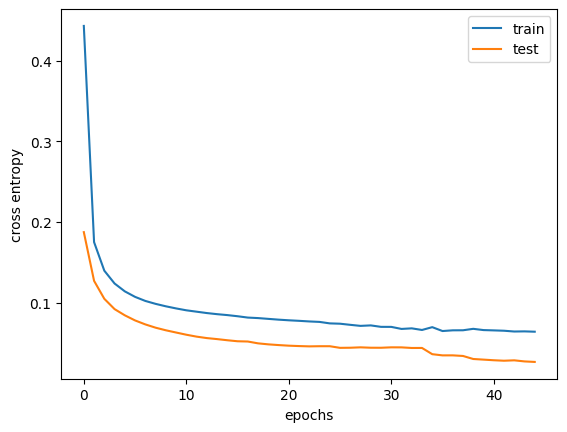

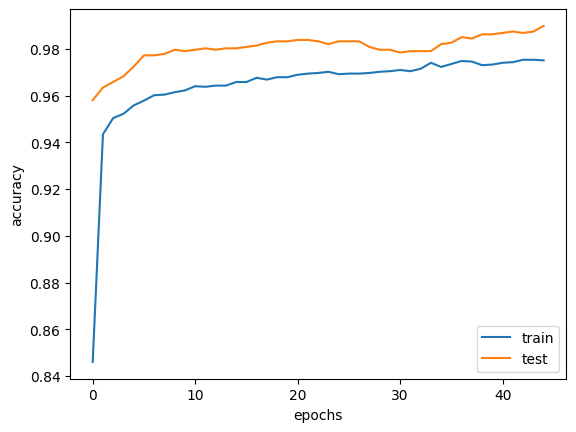

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [12]:
model.state_dict()

OrderedDict([('hidden.weight',
              tensor([[ 3.8722e+00, -1.9211e-01],
                      [ 5.3290e+00,  4.7047e-01],
                      [-5.1274e+00, -5.1903e-03],
                      [-2.1598e-01,  3.8066e+00],
                      [ 8.6600e-02, -8.0032e+00],
                      [ 5.6373e+00, -1.5221e-01],
                      [ 1.2375e+00,  4.9385e-01],
                      [ 3.5665e+00,  3.5465e-01]])),
             ('hidden.bias',
              tensor([ 3.1150, -1.4917,  2.9950,  2.6293, -2.0631,  3.2291,  1.8875, -1.5298])),
             ('output.weight',
              tensor([[  1.4272,  -6.1945,  -2.0182,   1.3436,   2.2910,   0.4987,   0.3354,
                        -3.3586],
                      [ -1.1558,  -0.3980,  -3.7244,  -1.4081,  -2.3210,  -1.6481,  -2.1048,
                        -0.4278],
                      [ -8.2870,  -1.0868,   0.8291,   0.7862, -21.4690, -17.1373,  -0.5934,
                        -0.1413],
                      [ -4.1